In [38]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [39]:
def format_model_name(key):
    if key == 'rnn_oja':
        return 'RNN-Oja'
    else:
        raise ValueError("Invalid key.")

In [40]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

# Collect aggregate metrics

In [45]:
# Collect measures of all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr_v1/"

init_sparsities = []
sigmas = []
gammas = []
lr_decays = []
lr_updates = []
clamp_mins = []
clamp_offsets = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    model_file = iter_path + 'model.pt'
                    if not os.path.exists(model_file): continue
                    state_dict = torch.load(model_file)
                    init_sparsities.append(init_sparsity)
                    sigmas.append(sigma)
                    gammas.append(gamma)
                    lr_decays.append(abs(state_dict['ca3.lr_decay'].item()))
                    lr_updates.append(abs(state_dict['ca3.lr_update'].item()))
                    clamp_mins.append(state_dict['ca3.clamp_min'].item())
                    clamp_offsets.append(abs(state_dict['ca3.clamp_offset'].item()))

init_sparsities = np.array(init_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
lr_decays = np.array(lr_decays)
lr_updates = np.array(lr_updates)
clamp_mins = np.array(clamp_mins)
clamp_offsets = np.array(clamp_offsets)

# Make 2D plots

In [42]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [36]:
def make_gradients(
    xs, ys, zs, cmap="Reds", interpolate=False,
    title=None, xlabel=None, ylabel=None, figname=None,
    smooth=False, contourz=None, figsize=[6.4, 4.8],
    plottype='relative'
    ):
    
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            xy_idx = np.logical_and(xs==x[i,j], ys==y[i,j])
            val = np.nanmean(zs[xy_idx])
            z[i,j] = val

    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots()
    im = ax.pcolormesh(
        x.astype(float), y.astype(float), z
        )
    fig.colorbar(im, ax=ax)
    ax.set_title('pcolormesh with levels')
    plt.show()
            
    if interpolate:
        nan_mask = np.isnan(z)
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X.astype(float), data_y.astype(float))

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten().astype(float),
                 y[nan_mask].flatten().astype(float)]).T
                )
            z[nan_mask] = interp_vals
        
    if smooth:
        from scipy.ndimage.filters import gaussian_filter
        z = gaussian_filter(z, 1.)
        
    #levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    
    # contours are *point* based plots, so convert our bound into point
    # centers
    fig, ax = plt.subplots(figsize=figsize)
    cf = ax.contourf(x.astype(float),#[:-1, :-1] + dx/2.,
                     y.astype(float),#[:-1, :-1] + dy/2.,
                     z, levels=levels
                     )
    if contourz is not None:
        cntrs = plt.contour(
            x.astype(float), y.astype(float), contourz, [1.0],
            colors='dimgray'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


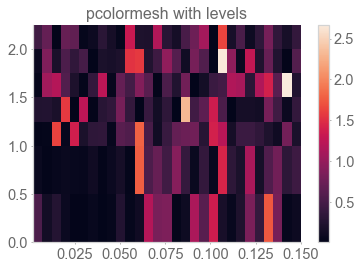

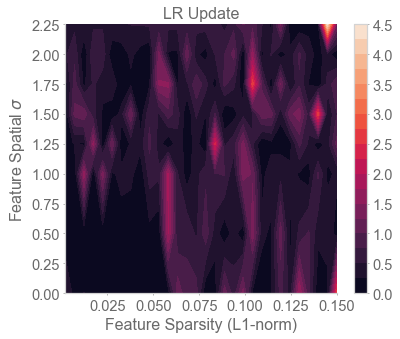

In [46]:
_gamma = 0.75
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_lr_updates = lr_updates[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas, _lr_updates,
    title='LR Update',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


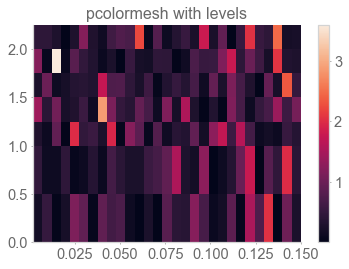

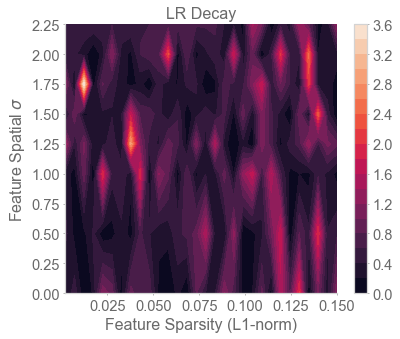

In [47]:
_gamma = 0.75
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_lr_decays = lr_decays[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas, _lr_decays,
    title='LR Decay',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


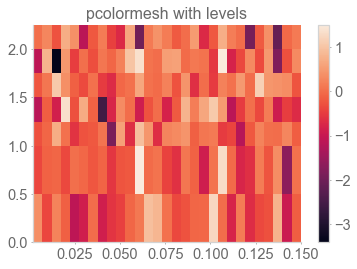

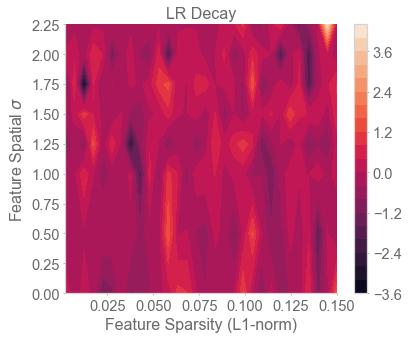

In [48]:
_gamma = 0.75
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_lr_updates = lr_updates[gammas==_gamma]
_lr_decays = lr_decays[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas, _lr_updates - _lr_decays,
    title='LR Decay',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


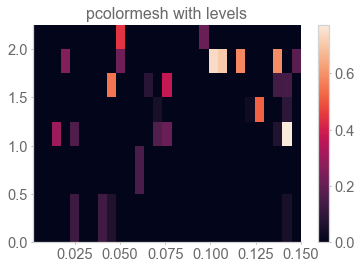

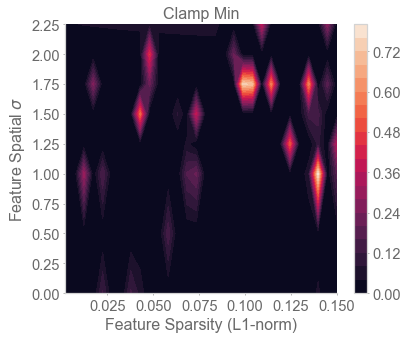

In [49]:
_gamma = 0.75
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_clamp_mins = np.clip(clamp_mins[gammas==_gamma], 0, 1E5)

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas, _clamp_mins,
    title='Clamp Min',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


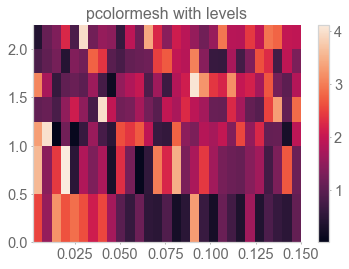

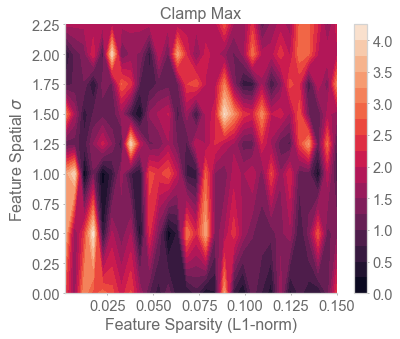

In [50]:
_gamma = 0.75
_init_sparsities = init_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_clamp_offsets = clamp_offsets[gammas==_gamma]

_x, _y, _z = make_gradients(
    _init_sparsities, _sigmas, _clamp_offsets,
    title='Clamp Max',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'test{_gamma}',
    interpolate=True, smooth=False, figsize=[6,5]
    )